GIGA Function:

In [ ]:
import numpy as np
import time
import logging

# --- GIGA Algorithm Implementation ---
def giga(L_all, L_target, M, TOL=1e-10):
    D, N = L_all.shape

    # Normalize the target vector
    norm_L_target = np.linalg.norm(L_target)
    if norm_L_target < TOL:
        logging.warning("Target vector norm is close to zero. Returning zero weights.")
        return np.zeros(N)
    l = L_target / norm_L_target

    # Normalize each column of L_all
    norms_L_n = np.linalg.norm(L_all, axis=0)
    if np.any(norms_L_n < TOL):
        raise ValueError("All input vectors (L_n) must have non-zero norms.")
    l_n_all = L_all / norms_L_n

    # Initialize weights
    w = np.zeros(N)

    for t in range(M):
        L_w_t = L_all @ w
        norm_L_w_t = np.linalg.norm(L_w_t)

        if norm_L_w_t < TOL:
            l_w_t = np.zeros(D)
        else:
            l_w_t = L_w_t / norm_L_w_t

        # Compute geodesic direction for target
        dot_l_lwt = np.dot(l, l_w_t)
        d_t_num = l - dot_l_lwt * l_w_t
        norm_d_t_num = np.linalg.norm(d_t_num)

        if norm_d_t_num < TOL:
            logging.info(f"Convergence reached at iteration {t}, d_t is zero.")
            break

        d_t = d_t_num / norm_d_t_num

        # Compute geodesic directions for each L_n
        dot_ln_lwt = np.dot(l_n_all.T, l_w_t)
        d_tn_all_num = l_n_all - l_w_t[:, np.newaxis] * dot_ln_lwt
        norm_d_tn_all_num = np.linalg.norm(d_tn_all_num, axis=0)

        scores = np.full(N, -np.inf)
        valid_indices = norm_d_tn_all_num > TOL

        if np.any(valid_indices):
            d_tn_valid = d_tn_all_num[:, valid_indices] / norm_d_tn_all_num[valid_indices]
            scores[valid_indices] = np.dot(d_t, d_tn_valid)

        # if np.all(np.isneginf(scores)):
        #     logging.info(f"No valid geodesic direction found at iteration {t}.")
        #     break

        n_t = np.argmax(scores)
        l_nt = l_n_all[:, n_t]

        # Compute step size
        zeta0 = np.dot(l, l_nt)
        zeta1 = dot_l_lwt
        zeta2 = dot_ln_lwt[n_t]

        num_gamma = zeta0 - zeta1 * zeta2
        den_gamma = num_gamma + (zeta1 - zeta0 * zeta2)

        if abs(den_gamma) < TOL:
            logging.info(f"Step size denominator is zero at iteration {t}.")
            break

        gamma_t = np.clip(num_gamma / den_gamma, 0.0, 1.0)

        # Correct Frank-Wolfe style weight update (NO normalization here)
        w = (1 - gamma_t) * w
        w[n_t] += gamma_t

    # Final least-squares scaling
    L_w_M = L_all @ w
    norm_sq_L_w_M = np.dot(L_w_M, L_w_M)

    if norm_sq_L_w_M > TOL:
        final_scale = np.dot(L_target, L_w_M) / norm_sq_L_w_M
        w *= final_scale

    # Enforce non-negativity
    w[w < 0] = 0.0

    return w

**Construct 20 independent datasets sampled from a Gaussian distribution. Apply the GIGA algorithm to each dataset for coreset construction, and evaluate the performance in terms of approximation error, computational time, and coreset size.**

In [ ]:

# --- Experiment Setup ---
def run_experiment_giga_only():
    # Configure logging to show info messages from the giga function
    logging.basicConfig(level=logging.WARNING, format='%(levelname)s: %(message)s')

    # Experiment parameters
    num_datasets = 20
    num_vectors_per_dataset = int(100000) # 1,000,000
    vector_dimension = 10
    coreset_sizes = [10, 100, 1000, 10000] # These are the 'M' values

    # Store results: [dataset_idx][m_idx] = (value)
    results_errors = np.zeros((num_datasets, len(coreset_sizes)))
    results_sizes = np.zeros_like(results_errors)
    results_times = np.zeros_like(results_errors)

    rng_experiment = np.random.default_rng(42) # RNG for reproducible datasets

    print("Starting GIGA-only experiment...")
    print(f"Number of datasets: {num_datasets}")
    print(f"Vectors per dataset (N): {num_vectors_per_dataset}")
    print(f"Vector dimension (D): {vector_dimension}")
    print(f"Coreset sizes (M): {coreset_sizes}")

    for i in range(num_datasets):
        print(f"\n--- Dataset {i+1}/{num_datasets} ---")

        # Generate the dataset (L_all) and the target vector (L_target)
        # We generate data as (N, D) and then transpose it to (D, N)
        dataset_A = rng_experiment.normal(loc=0, scale=1, size=(num_vectors_per_dataset, vector_dimension))
        dataset_b = rng_experiment.normal(loc=0, scale=1, size=vector_dimension)

        # Ensure target and columns have non-zero norm
        if np.linalg.norm(dataset_b) < 1e-10:
            dataset_b[0] += 1e-9

        L_all = dataset_A.T # Shape (D, N) = (50, 1,000,000)
        L_target = dataset_b    # Shape (D,) = (50,)

        for j, M_val in enumerate(coreset_sizes):
            print(f"  Processing M = {M_val} for GIGA...")

            start_time_giga = time.time()

            # Run the GIGA algorithm
            w_final = giga(L_all, L_target, M=M_val)

            time_giga = time.time() - start_time_giga

            # Calculate final error and coreset size
            err_giga = np.linalg.norm((L_all @ w_final) - L_target)
            size_giga = np.sum(w_final > 1e-10)

            results_errors[i, j] = err_giga
            results_sizes[i, j] = size_giga
            results_times[i, j] = time_giga

            print(f"    GIGA: Error={err_giga:.4e}, Size={size_giga}, Time={time_giga:.2f}s")

    # --- Aggregate and Print Results ---
    print("\n--- GIGA Experiment Summary ---")
    avg_errors = np.mean(results_errors, axis=0)
    avg_sizes = np.mean(results_sizes, axis=0)
    avg_times = np.mean(results_times, axis=0)

    print("\nAverage Reconstruction Error (||L_all * w - L_target||_2) for GIGA:")
    print("{:<10} {:<15}".format("M", "GIGA Error"))
    for j, M_val in enumerate(coreset_sizes):
        print("{:<10} {:<15.4e}".format(M_val, avg_errors[j]))

    print("\nAverage Coreset Size for GIGA:")
    print("{:<10} {:<15}".format("M", "GIGA Size"))
    for j, M_val in enumerate(coreset_sizes):
        print("{:<10} {:<15.2f}".format(M_val, avg_sizes[j]))

    print("\nAverage Runtime (seconds) for GIGA:")
    print("{:<10} {:<15}".format("M", "GIGA Time"))
    for j, M_val in enumerate(coreset_sizes):
        print("{:<10} {:<15.2f}".format(M_val, avg_times[j]))

    return results_errors, results_sizes, coreset_sizes

# run_experiment_giga_only()
results_errors, results_sizes, coreset_sizes = run_experiment_giga_only()

Starting GIGA-only experiment...
Number of datasets: 20
Vectors per dataset (N): 100000
Vector dimension (D): 10
Coreset sizes (M): [10, 100, 1000, 10000]

--- Dataset 1/20 ---
  Processing M = 10 for GIGA...
    GIGA: Error=2.4029e-02, Size=10, Time=0.25s
  Processing M = 100 for GIGA...
    GIGA: Error=3.3675e-04, Size=97, Time=2.23s
  Processing M = 1000 for GIGA...
    GIGA: Error=2.9969e-10, Size=430, Time=10.60s
  Processing M = 10000 for GIGA...
    GIGA: Error=2.9969e-10, Size=430, Time=11.86s

--- Dataset 2/20 ---
  Processing M = 10 for GIGA...
    GIGA: Error=1.7428e-01, Size=10, Time=0.23s
  Processing M = 100 for GIGA...
    GIGA: Error=1.7428e-01, Size=10, Time=2.19s
  Processing M = 1000 for GIGA...
    GIGA: Error=1.7428e-01, Size=10, Time=26.96s
  Processing M = 10000 for GIGA...
    GIGA: Error=1.7428e-01, Size=10, Time=251.97s

--- Dataset 3/20 ---
  Processing M = 10 for GIGA...
    GIGA: Error=2.0497e-03, Size=10, Time=0.47s
  Processing M = 100 for GIGA...
    GIG

Average Reconstruction Error (||L_all * w - L_target||_2) for GIGA:
M          GIGA Error     
10         1.8613e-03     
100        3.1050e-10     
1000       2.2926e-10     
10000      2.2926e-10     


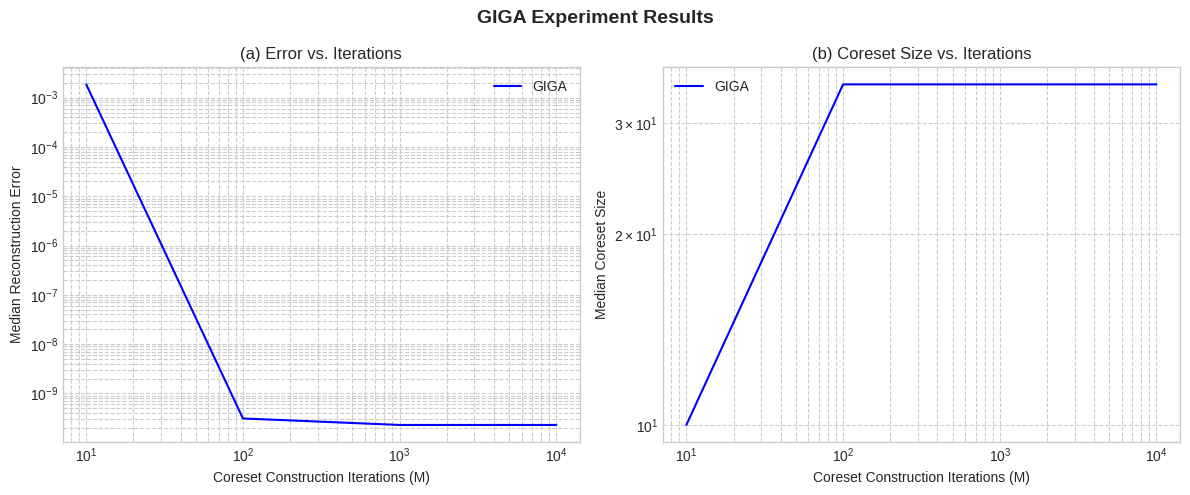

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_giga_experiment(results_errors, results_sizes, coreset_sizes):
    # Use MEDIAN across datasets, not individual ones (as in the paper)
    avg_errors = np.median(results_errors, axis=0)
    avg_sizes = np.median(results_sizes, axis=0)

    print("Average Reconstruction Error (||L_all * w - L_target||_2) for GIGA:")
    print("{:<10} {:<15}".format("M", "GIGA Error"))
    for j, M_val in enumerate(coreset_sizes):
        print("{:<10} {:<15.4e}".format(M_val, avg_errors[j]))
    plt.figure(figsize=(12, 5))

    # Plot Error vs Iterations (left subplot)
    plt.subplot(1, 2, 1)
    plt.plot(coreset_sizes, avg_errors, label="GIGA", color='blue')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Coreset Construction Iterations (M)")
    plt.ylabel("Median Reconstruction Error")
    plt.title("(a) Error vs. Iterations")
    plt.legend()
    plt.grid(True, which="both", linestyle='--')


    # Plot Coreset Size vs Iterations (right subplot)
    plt.subplot(1, 2, 2)
    plt.plot(coreset_sizes, avg_sizes, label="GIGA", color='blue')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Coreset Construction Iterations (M)")
    plt.ylabel("Median Coreset Size")
    plt.title("(b) Coreset Size vs. Iterations")
    plt.legend()
    plt.grid(True, which="both", linestyle='--')


    plt.suptitle("GIGA Experiment Results", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


plot_giga_experiment(results_errors, results_sizes, coreset_sizes)



Postrior Analysis of GIGA:

  0%|          | 0/1000 [00:00<?, ?it/s]

Median Relative Error for GIGA (M=1, N=10, 1000 reps): 2.22%


  0%|          | 0/1000 [00:00<?, ?it/s]

Median Relative Error for GIGA (M=2, N=10, 1000 reps): 0.50%


  0%|          | 0/1000 [00:00<?, ?it/s]

Median Relative Error for GIGA (M=3, N=10, 1000 reps): 0.07%


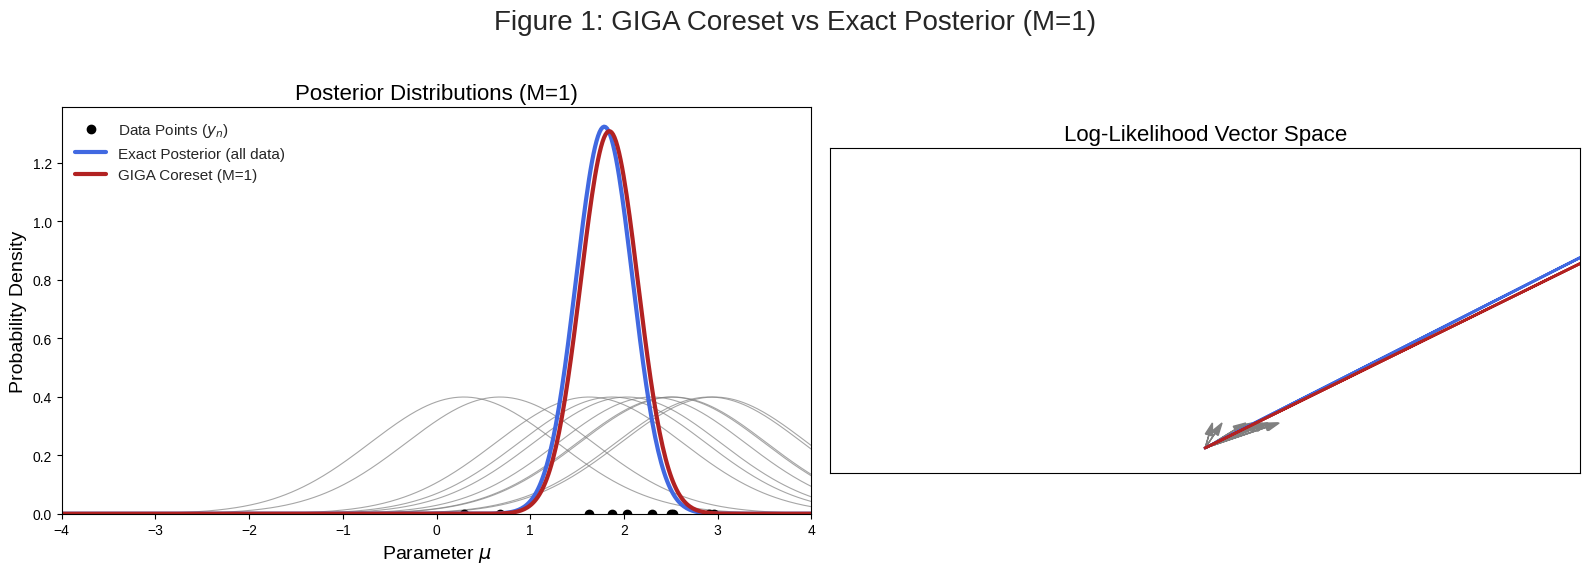

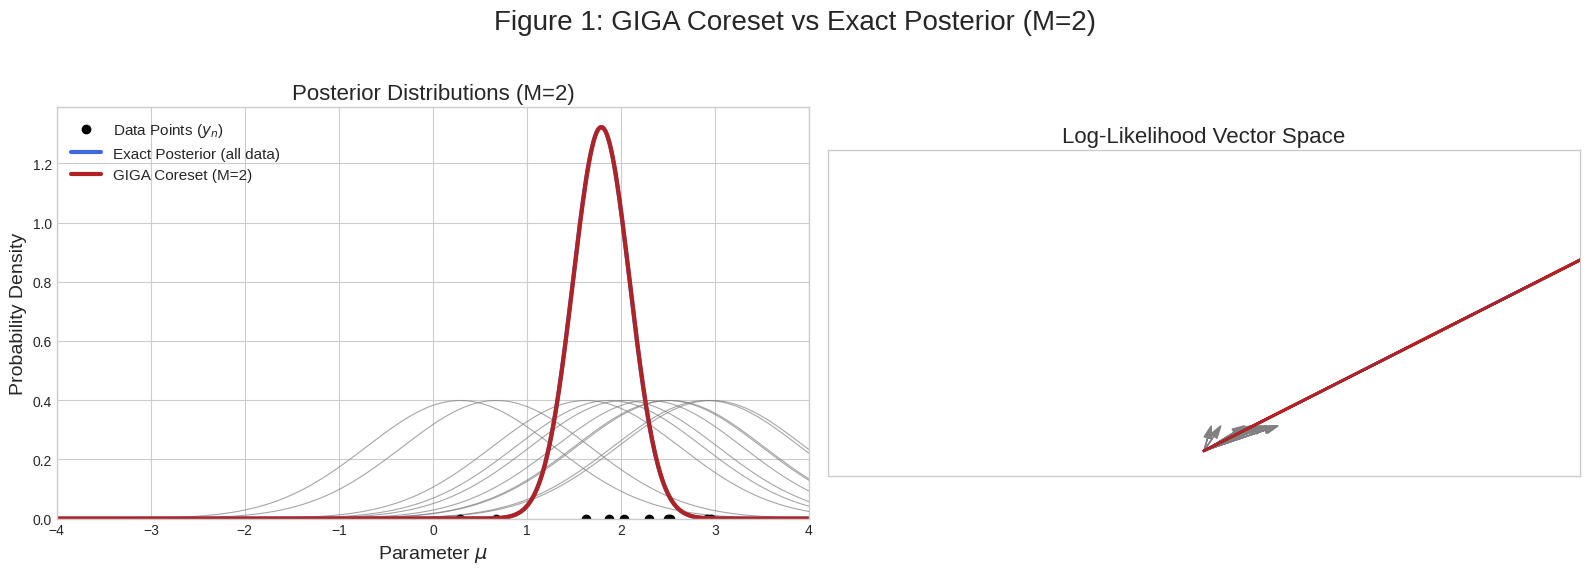

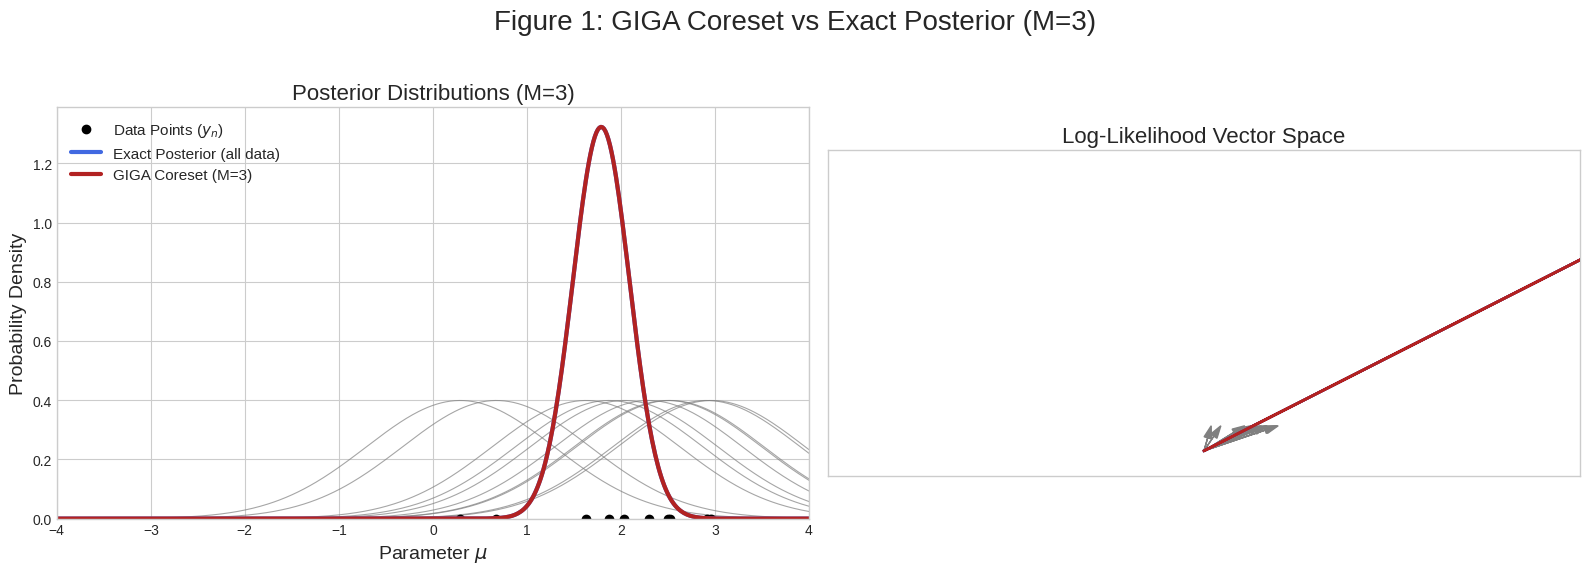

In [ ]:
import numpy as np
import time
import logging
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm.auto import tqdm


def compute_median_relative_error(M, N=10, num_iter=1000):
    prior_var = 1.0
    data_var = 1.0
    all_errors = []

    for _ in tqdm(range(num_iter)):
        mu = np.random.normal(0, np.sqrt(prior_var))
        y_data = np.random.normal(mu, np.sqrt(data_var), size=N)

        Ln = np.vstack((y_data, np.ones(N))).T
        L_target = Ln.sum(axis=0)

        full_posterior_var = 1. / (1./prior_var + N/data_var)

        w = giga(Ln.T, L_target, M)
        sum_weights = np.sum(w)
        coreset_posterior_var = 1. / (1./prior_var + sum_weights/data_var)

        relative_error = abs(coreset_posterior_var - full_posterior_var) / full_posterior_var
        all_errors.append(relative_error)

    median_error = np.median(all_errors)
    return median_error

def print_error(M, N, num_iter):
    median_error = compute_median_relative_error(M, N, num_iter)
    print(f"Median Relative Error for GIGA (M={M}, N={N}, {num_iter} reps): {median_error*100:.2f}%")

for i in range (1,4):
     print_error(i, 10, 1000)

def generate_giga(M, y_data, Ln):
    N = 10
    prior_mean, prior_var = 0., 1.
    data_var = 1.

    # mu_true = np.random.normal(prior_mean, np.sqrt(prior_var))
    # y_data = np.random.normal(mu_true, np.sqrt(data_var), N)
    # Ln = np.vstack((y_data, np.ones(N))).T

    # GIGA coreset
    w_giga = giga(Ln.T, Ln.sum(axis=0), M)
    giga_coreset_vector = Ln.T @ w_giga
    L_full = np.sum(Ln, axis=0)

    def get_posterior_params(weights, data):
        post_var = 1.0 / (1.0 / prior_var + np.sum(weights) / data_var)
        post_mean = post_var * (prior_mean / prior_var + np.sum(weights * data) / data_var)
        return post_mean, post_var

    mu_post_full, var_post_full = get_posterior_params(np.ones(N), y_data)
    mu_post_giga, var_post_giga = get_posterior_params(w_giga, y_data)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plt.style.use('seaborn-v0_8-whitegrid')
    mu_grid = np.linspace(-4, 4, 500)

    #  Posterior distributions
    ax = axes[0]
    for y_n in y_data:
        ax.plot(mu_grid, norm.pdf(mu_grid, y_n, np.sqrt(data_var)), color='gray', lw=0.8, alpha=0.7)
    ax.plot(y_data, np.zeros(N), 'o', color='black', markersize=6, label='Data Points ($y_n$)')
    ax.plot(mu_grid, norm.pdf(mu_grid, mu_post_full, np.sqrt(var_post_full)),
            color='royalblue', lw=3, label='Exact Posterior (all data)')
    ax.plot(mu_grid, norm.pdf(mu_grid, mu_post_giga, np.sqrt(var_post_giga)),
            color='firebrick', lw=3, label=f'GIGA Coreset (M={M})')
    ax.set_xlabel('Parameter $\mu$', fontsize=14)
    ax.set_ylabel('Probability Density', fontsize=14)
    ax.set_title(f'Posterior Distributions (M={M})', fontsize=16)
    ax.legend(fontsize=11)
    ax.set_ylim(bottom=0)
    ax.set_xlim(mu_grid.min(), mu_grid.max())

    # RIGHT: Log-likelihood vector space
    ax = axes[1]
    for i in range(N):
        ax.arrow(0, 0, Ln[i, 0], Ln[i, 1], head_width=0.3, head_length=0.5,
                 fc='gray', ec='gray', length_includes_head=True)
    ax.arrow(0, 0, L_full[0], L_full[1], head_width=0.3, head_length=0.5,
             fc='royalblue', ec='royalblue', lw=2, length_includes_head=True, zorder=3)
    ax.arrow(0, 0, giga_coreset_vector[0], giga_coreset_vector[1], head_width=0.3, head_length=0.5,
             fc='firebrick', ec='firebrick', lw=2, length_includes_head=True, zorder=4)
    ax.plot(L_full[0], L_full[1], '*', color='deepskyblue', markersize=18, zorder=5, markeredgecolor='white')
    ax.set_title('Log-Likelihood Vector Space', fontsize=16)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-1, 12)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.suptitle(f'Figure 1: GIGA Coreset vs Exact Posterior (M={M})', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"figure1_giga_M{M}.png")
    plt.show()


# Run experiments for M = 1, 2, 3
N = 10
prior_mean, prior_var = 0., 1.
data_var = 1.

mu_true = np.random.normal(prior_mean, np.sqrt(prior_var))
y_data = np.random.normal(mu_true, np.sqrt(data_var), N)
Ln = np.vstack((y_data, np.ones(N))).T

for M in [1, 2, 3]:
    generate_giga(M, y_data, Ln)